# Visualize Amazon SageMaker Training Jobs with TensorBoard

This notebook shows how to use TensorBoard to visualize both local and remote training jobs as well as jobs run by Amazon SageMaker Automatic Model Tuning. The notebook uses an external S3 Bucket to store TensorFlow logs. This allows data scientists to use TensorBoard to visualize all past training jobs. TensorBoard can be hosted in SageMaker Notebook Instance, on a local computer or an instance running on AWS.

All TensorFlow logs used by TensorBoard are generated in training script `source_dir/tensorboard_keras_cifar10.py`. It includes code demonstrating how to log accuracy and loss for every epoch during training and validation, calculate and log confusion matrices and images, visualize model architecture, calculate weights distributions and histograms, and compare hyperparameter tuning jobs. The script follows the official [TensorBoard guide](https://www.tensorflow.org/tensorboard/get_started), so you can reference the documentation and easily adjust the code to your needs.

## Set up the environment

Upgrading SageMaker python SDK and TensorFlow to the current latest version. We need to restart the notebook's kernel to use the newly installed version.
**The following command will upgrade packages in your current kernel environment, which can affect other notebooks using the same kernel.**

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade grpcio sagemaker==1.60.* awscli==1.* tensorflow==2.2.* tensorboard_plugin_profile==2.2.*

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (20.2.2)
Requirement already up-to-date: grpcio in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (1.31.0)
Requirement already up-to-date: sagemaker==1.60.* in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (1.60.2)
  Using cached awscli-1.18.131-py2.py3-none-any.whl (3.3 MB)
Requirement already up-to-date: tensorflow==2.2.* in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (2.2.0)
Requirement already up-to-date: tensorboard_plugin_profile==2.2.* in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (2.2.0)
     |████████████████████████████████| 6.6 MB 10.3 MB/s eta 0:00:01


  Attempting uninstall: botocore
    Found existing installation: botocore 1.17.52
    Uninstalling botocore-1.17.52:
      Successfully uninstalled botocore-1.17.52
  Attempting uninstall: awscli
    Found existing installation: awscli 1.18.129
    Uninstalling awscli-1.18.129:
      Successfully uninstalled awscli-1.18.129


In [ ]:
%%javascript
Jupyter.notebook.kernel.restart()

<IPython.core.display.Javascript object>

This notebook is using the default SageMaker's S3 bucket. Tensorflow logs will be written to `s3://sagemaker-<region>-<account_id>/tensorboard_keras_cifar10/logs`.

In [21]:
import os
import sagemaker
from sagemaker import get_execution_role
import tensorflow as tf
from tensorflow import keras

sagemaker_session = sagemaker.Session()

role = get_execution_role()

bucket = 'virtual-regatta-ml'
data_bucket = 'virtual-regatta'
prefix = 'keras'
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, prefix)

print('Bucket: {}'.format(bucket))
print('Tensorflow ver: ' + tf.__version__)

Bucket: virtual-regatta-ml
Tensorflow ver: 2.2.0


## Download the dataset

In [22]:
import boto3

def downloadDirectoryFroms3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucketName) 
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key)

In [23]:
folder = 'logs_players/'

downloadDirectoryFroms3(data_bucket, folder)

In [24]:
from os.path import join
import pandas as pd

def aggregate_players_record(folder) :
    df_global = pd.DataFrame(columns=['boat_speed','wind_speed', 'angle_of_attack','target_angle','boat_angle'])
    for file in os.listdir(folder):
        df = pd.read_csv(join(folder, file), usecols=['boat_speed','wind_speed', 'angle_of_attack','target_angle','boat_angle'])
        df_global = df_global.append(df, ignore_index=True)
    return df_global

In [25]:
data = aggregate_players_record(folder)

display(data.head())

display(data.describe())

,boat_speed,wind_speed,angle_of_attack,target_angle,boat_angle
0,9.57241,21.07713,87.99948,175.65816,115.66020
1,9.55964,20.86005,87.99948,175.65816,116.28877
2,9.55918,20.85209,87.99948,175.65816,116.23885
3,9.54864,20.67299,87.99948,175.65816,117.05241
4,9.54816,20.66480,87.99948,175.65816,116.94048


,boat_speed,wind_speed,angle_of_attack,target_angle,boat_angle
count,680.000000,680.000000,680.000000,680.000000,680.000000
mean,9.733222,19.655013,93.789899,176.392811,120.137296
std,0.334205,1.736218,2.842815,2.510255,7.839105
min,8.504780,13.650740,86.495660,142.000000,113.252390
25%,9.782100,19.959193,93.137740,175.658160,116.726540
50%,9.865355,20.186410,94.991800,175.761089,117.659720
75%,9.883450,20.312140,95.024220,175.961350,119.514300
max,9.954010,21.077130,108.382870,182.819988,148.000000


In [27]:
import numpy as np

rand_split = np.random.rand(len(data))
train_list = rand_split < 0.85
test_list = rand_split >= 0.85

data_train = data[train_list]
data_test = data[test_list]

y_train = data_train.iloc[:,-1].to_numpy();
x_train = data_train.iloc[:,:-1].to_numpy();

y_test = data_test.iloc[:,-1].to_numpy();
x_test = data_test.iloc[:,:-1].to_numpy();

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (594, 4)
y_train shape: (594,)
594 train samples
86 test samples


In [28]:
import io
import sagemaker.amazon.common as smac

train_file = 'linear_train.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, x_train.astype('float32'), y_train.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)
train_input = "s3://{}/{}/train/".format(bucket, prefix)
print(train_input)

s3://virtual-regatta-ml/keras/train/


In [29]:
validation_file = 'linear_validation.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, x_test.astype('float32'), y_test.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)
validation_input = "s3://{}/{}/validation/".format(bucket, prefix)
print(validation_input)

s3://virtual-regatta-ml/keras/validation/


In [3]:
import os

if not os.path.exists('./data/validation'):
    os.makedirs('./data/validation')

if not os.path.exists('./data/train'):
    os.makedirs('./data/train')

def write_tfrecords(x, y, filename):
    writer = tf.io.TFRecordWriter(filename)

    for image, label in zip(x, y):
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }))
        writer.write(example.SerializeToString())

write_tfrecords(x_test, y_test, './data/validation/validation.tfrecords')

write_tfrecords(x_train, y_train, './data/train/train.tfrecords')

## Create a training job using the sagemaker.TensorFlow estimator, running locally
To test that the code will work in SageMaker, we'll first use SageMaker local mode.

In [30]:
from sagemaker.tensorflow import TensorFlow

hyperparameters = {'epochs': 10, 'batch-size' : 64, 'tf-logs-path': tensorflow_logs_path}

inputs = {'train': train_input, 'validation': validation_input}

estimator = TensorFlow(base_job_name='tensorboard-example-local',
                       entry_point='tensorboard_keras.py',
                       source_dir='source_dir',
                       role=role,
                       framework_version='2.2.0',
                       py_version='py37',
                       hyperparameters=hyperparameters,
                       train_instance_count=1,
                       train_instance_type='local')

estimator.fit(inputs)

Legacy mode is deprecated in versions 1.13 and higher. Using script mode instead. Legacy mode and its training parameters will be deprecated in SageMaker Python SDK v2. Please use TF 1.13 or higher and script mode.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmphcp0nw6s_algo-1-iqobz_1 ... 
Attaching to tmphcp0nw6s_algo-1-iqobz_12mdone
algo-1-iqobz_1  | 2020-09-03 12:11:09,418 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-iqobz_1  | 2020-09-03 12:11:09,426 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-iqobz_1  | 2020-09-03 12:11:10,632 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
algo-1-iqobz_1  | /usr/local/bin/python3.7 -m pip install -r requirements.txt
algo-1-iqobz_1  | Collecting matplotlib==3.2.1
algo-1-iqobz_1  |   Downloading matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)
     |████████████████████████████████| 12.4 MB 11.2 MB/s eta 0:00:01
algo-1-iqobz_1  | Collecting keras==2.4.3
algo-1-iqobz_1  |   Downloading Keras-2.4.3-py2.py3-none-any.whl (36 kB)
algo-1-iqobz_1  | Requirement already satisfied: numpy>=1.11 in /usr/local/lib/python3.7/site-packages (from matplotlib==3.2

algo-1-iqobz_1  | Epoch 1/10
algo-1-iqobz_1  | 2020-09-03 12:11:20,759 sagemaker-training-toolkit ERROR    ExecuteUserScriptError:
algo-1-iqobz_1  | Command "/usr/local/bin/python3.7 tensorboard_keras.py --batch-size 64 --epochs 10 --model_dir s3://sagemaker-eu-west-2-281633979087/tensorboard-example-local-2020-09-03-12-11-02-553/model --tf-logs-path s3://virtual-regatta-ml/keras/logs"
algo-1-iqobz_1  | INFO:root:Writing TensorBoard logs to s3://virtual-regatta-ml/keras/logs/tensorboard-example-local-2020-09-03-12-11-02-553
algo-1-iqobz_1  | INFO:root:Running train in File mode
algo-1-iqobz_1  | INFO:root:Running validation in File mode
algo-1-iqobz_1  | Traceback (most recent call last):
algo-1-iqobz_1  |   File "tensorboard_keras.py", line 224, in <module>
algo-1-iqobz_1  |     main(args)
algo-1-iqobz_1  |   File "tensorboard_keras.py", line 183, in main
algo-1-iqobz_1  |     callbacks=callbacks)
algo-1-iqobz_1  |   File "/usr/local/lib/python3.7/site-packages/tensorflow/python/keras

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


tmphcp0nw6s_algo-1-iqobz_1 exited with code 1
Aborting on container exit...


RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmphcp0nw6s/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1

## Run on SageMaker cloud

### Uploading the data to s3

In [5]:
dataset_location = sagemaker_session.upload_data(path='data', key_prefix=prefix + '/data')
display(dataset_location)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


's3://sagemaker-eu-west-2-281633979087/tensorboard_keras_cifar10/data'

### Configuring metrics from the job logs
SageMaker can get training metrics directly from the logs and send them to CloudWatch metrics.

In [6]:
keras_metric_definition = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - accuracy: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_accuracy: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* (\d+)[mu]s/step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: [0-9\\.]+'}
]

### Train image classification based on the cifar10 dataset

We are going to train the model with Pipe Mode input. SageMaker Pipe Mode is a mechanism for providing S3 data to a training job via Linux fifos. Training programs can read from the fifo and get high-throughput data transfer from S3, without managing the S3 access in the program itself.
Pipe Mode is covered in more detail in the SageMaker [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-trainingdata).

In [7]:
hyperparameters = {'epochs': 2, 'batch-size' : 256, 'tf-logs-path': tensorflow_logs_path}

inputs = {'train' : dataset_location+'/train', 'validation' : dataset_location+'/validation'}

estimator = TensorFlow(base_job_name='tensorboard-example',
                       entry_point='tensorboard_keras_cifar10.py',
                       source_dir='source_dir',
                       role=role,
                       framework_version='2.2.0',
                       py_version='py37',
                       hyperparameters=hyperparameters,
                       train_instance_count=1,
                       train_instance_type='ml.c5.xlarge',
                       metric_definitions=keras_metric_definition,
                       input_mode='Pipe')

estimator.fit(inputs, wait=True)

Legacy mode is deprecated in versions 1.13 and higher. Using script mode instead. Legacy mode and its training parameters will be deprecated in SageMaker Python SDK v2. Please use TF 1.13 or higher and script mode.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-01 14:16:57 Starting - Starting the training job...
2020-09-01 14:16:59 Starting - Launching requested ML instances......
2020-09-01 14:18:05 Starting - Preparing the instances for training...
2020-09-01 14:18:48 Downloading - Downloading input data
2020-09-01 14:18:48 Training - Downloading the training image...
2020-09-01 14:19:07 Training - Training image download completed. Training in progress.2020-09-01 14:19:10,683 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-09-01 14:19:10,691 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-01 14:19:10,974 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/usr/local/bin/python3.7 -m pip install -r requirements.txt
2020-09-01 14:19:13,645 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-01 14:19:13,659 sagemaker-training-toolkit INFO     No GPUs detected (normal if no

#015      1/Unknown - 0s 15us/step - loss: 7.1821 - accuracy: 0.0977#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015      2/Unknown - 0s 237ms/step - loss: 1600.6794 - accuracy: 0.0918#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015      3/Unknown - 1s 289ms/step - loss: 1074.8619 - accuracy: 0.0911#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

 loss: 28.7159 - accuracy: 0.0969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    123/Unknown - 44s 358ms/step - loss: 28.5012 - accuracy: 0.0969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    124/Unknown - 44s 358ms/step - loss: 28.2899 - accuracy: 0.0969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    125/Unknown -

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    244/Unknown - 84s 345ms/step - loss: 15.5095 - accuracy: 0.0975#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    245/Unknown - 84s 345ms/step - loss: 15.4556 - accuracy: 0.0975#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    246/Unknown - 85s 345ms/step - loss: 15.4021 - accuracy: 0.0973#010#010#010#010#010#010#010#010#010#010#010#01

#010#010#010#010#010#010#010#010#010#010#010#015    364/Unknown - 123s 339ms/step - loss: 11.1558 - accuracy: 0.0974#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    365/Unknown - 124s 338ms/step - loss: 11.1315 - accuracy: 0.0975#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015    366/Unknown - 124s 338ms/step - loss: 11.1074 - accuracy: 0.0974#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015  1/390 [..............................] - ETA: 0s - loss: 2.3053 - accuracy: 0.1133#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  2/390 [..............................] - ETA: 1:13 - loss: 2.3050 - accuracy: 0.1055#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  3/390 [..............................] - ETA: 1:37 - loss: 2.3045 - accuracy: 0.0964#010#010#010#010#010#010#010#010#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 96/390 [======>.......................] - ETA: 1:50 - loss: 2.3030 - accuracy: 0.0971#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 97/390 [======>.......................] - ETA: 1:49 - loss: 2.3030 - accuracy: 0.0971#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

racy: 0.0980#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015191/390 [=============>................] - ETA: 1:15 - loss: 2.3030 - accuracy: 0.0981#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015192/390 [=============>................] - ETA: 1:14 - loss: 2.3030 - accuracy: 0.0981#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015286/390 [=====================>........] - ETA: 39s - loss: 2.3030 - accuracy: 0.0984#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015287/390 [=====================>........] - ETA: 38s - loss: 2.3031 - accuracy: 0.0984#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015382/390 [============================>.] - ETA: 3s - loss: 2.3030 - accuracy: 0.0986#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015383/390 [============================>.] - ETA: 2s - loss: 2.3030 - accuracy: 0.0986#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010


2020-09-01 14:24:40 Uploading - Uploading generated training model
2020-09-01 14:24:40 Failed - Training job failed


UnexpectedStatusException: Error for Training job tensorboard-example-2020-09-01-14-16-57-384: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/local/bin/python3.7 tensorboard_keras_cifar10.py --batch-size 256 --epochs 2 --model_dir s3://sagemaker-eu-west-2-281633979087/tensorboard-example-2020-09-01-14-16-57-384/model --tf-logs-path s3://sagemaker-eu-west-2-281633979087/tensorboard_keras_cifar10/logs"
INFO:root:Writing TensorBoard logs to s3://sagemaker-eu-west-2-281633979087/tensorboard_keras_cifar10/logs/tensorboard-example-2020-09-01-14-16-57-384
INFO:root:Running train in Pipe mode
INFO:root:Running validation in Pipe mode
2020-09-01 14:19:17.420651: W tensorflow/core/framework/dataset.cc:445] Input of PipeModeDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2020-09-01 14:21:31.872513: W tensorflow/core/framework/dataset.cc:445] Input of PipeModeDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2020-09-01 14:

The **```fit```** method will create a training job named **```tensorboard-example-{unique identifier}```** on **ml.c5.xlarge** instance.

These instances will write checkpoints and logs to the S3 bucket we've set up earlier. If you don't have this bucket yet, **```sagemaker_session```** will create it for you. These checkpoints and logs can be used for restoring the training job, and to analyze training job metrics using TensorBoard. 

## Hyperparameter tuning

Next, the tuning job with the following configurations need to be specified:
- hyperparameters that SageMaker Automatic Model Tuning will tune: `learning-rate`, `batch-size` and `optimizer`;
- maximum number of training jobs it will run to optimize the objective metric: `10`
- number of parallel training jobs that will run in the tuning job: `2`
- objective metric that Automatic Model Tuning will use: `validation:accuracy`

In [ ]:
shared_hyperparameters = {'epochs': 6, 'tf-logs-path': tensorflow_logs_path}

estimator = TensorFlow(base_job_name='tensorboard-example-hpo',
                       entry_point='tensorboard_keras_cifar10.py',
                       source_dir='source_dir',
                       role=role,
                       framework_version='2.2.0',
                       py_version='py37',
                       hyperparameters=shared_hyperparameters,
                       train_instance_count=1,
                       train_instance_type='ml.p3.2xlarge',
                       metric_definitions=keras_metric_definition,
                       input_mode='Pipe')

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'learning-rate': ContinuousParameter(0.00001, 0.001),
                         'batch-size': CategoricalParameter([64, 128, 256, 512]),
                         'optimizer': CategoricalParameter(['sgd', 'adam', 'rmsprop'])}

objective_metric_name = 'validation:accuracy'

inputs = {'train' : dataset_location+'/train', 'validation' : dataset_location+'/validation'}

tuner = HyperparameterTuner(estimator, 
                            objective_metric_name, 
                            hyperparameter_ranges,
                            metric_definitions=keras_metric_definition,
                            objective_type='Maximize', 
                            max_jobs=10, 
                            max_parallel_jobs=2,
                            early_stopping_type='Auto',
                            base_tuning_job_name='remote-hpo')

tuner.fit(inputs)

# TensorBoard

### Run TensorBoard inside SageMaker Notebooks

Now we can use TensorBoard to compare all training jobs, including local, cloud, tuning training. The following cell will run TensorBoard inside of the SageMaker Notebook Instance.

In [ ]:
aws_region = sagemaker_session.boto_region_name

!AWS_REGION={aws_region} tensorboard --logdir {tensorflow_logs_path}

[**Click here to access TensorBoard instance**](/proxy/6006/)

Instance of TensorBoard will be available at `https://<notebook instance hostname>/proxy/6006/`.
By default TensorBoard assigns port 6006, but if it's already in use TensorBoard will increase the port by 1, so 6007, 6008 and so on until it finds an avilable port.

You should something similar to this:
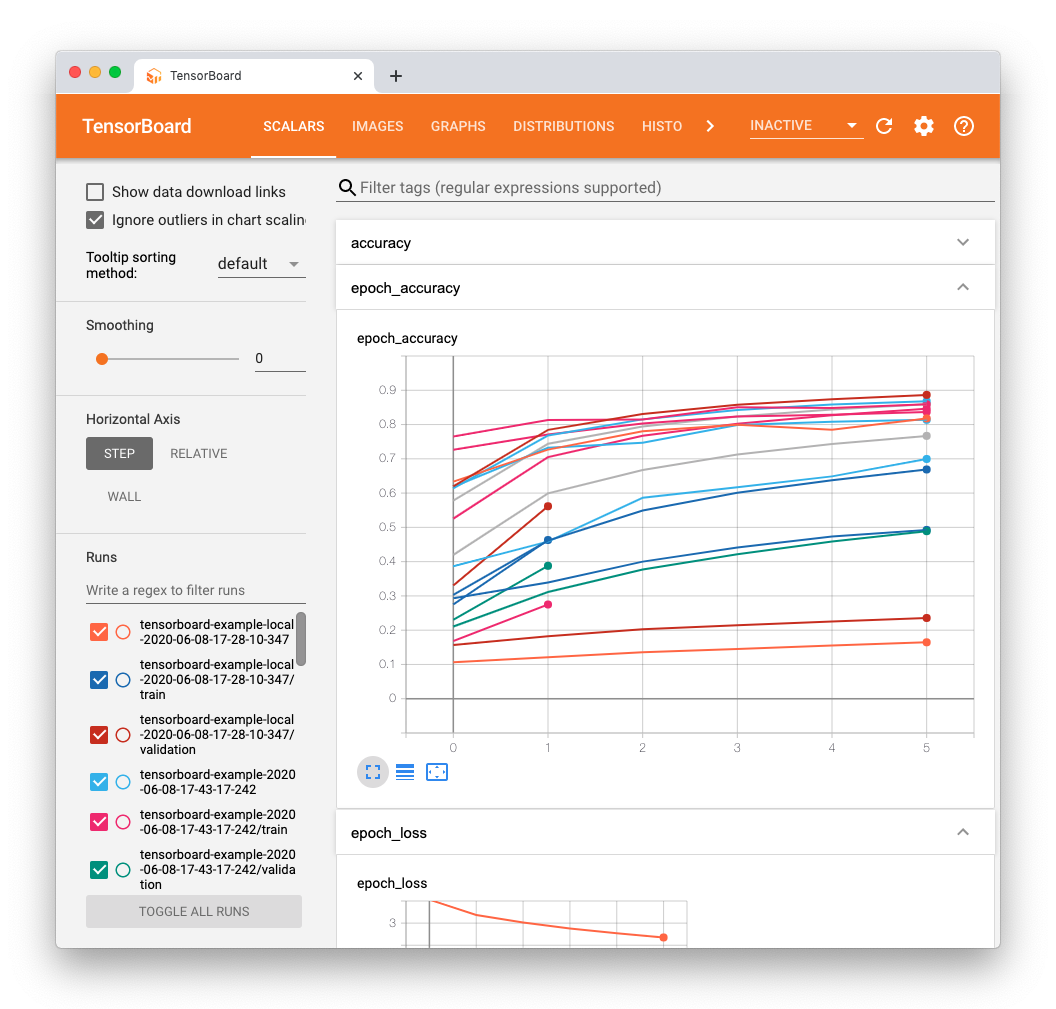


### Run TensorBoard locally

The same command can be used to run TensorBoard in any environment:
- install TensorFlow locally using `pip install tensorflow`
- profiling the model also requires Profiler plugin `pip install tensorboard_plugin_profile`
- configure AWS CLI and make sure you have read access to S3 bucket containing TensorFlow log files
- configure default AWS region. You can do this by setting an environment variable named `AWS_REGION` with region name where the S3 bucket is located, e.g. `export AWS_REGION=eu-west-1`
- start TensorBoard with a following command `tensorboard --logdir <S3_path_to_tensorflow_logs>`

Now you can access the local instance of TensorBoard at http://localhost:6006

# Cleaning up
To avoid incurring charges to your AWS account for the resources used in this tutorial you need to remove all TensorFlow log files and model artifacts from the SageMaker S3 bucket.